In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt

In [2]:
# # Generate synthetic sequential data
n_samples = 1000
n_features = 3
sequence_length = 20

# Generate random features
features = np.random.rand(n_samples, sequence_length, n_features)
labels = np.random.randint(0, 2, size=n_samples)

In [3]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(features, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [4]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, n_features)).reshape(-1, sequence_length, n_features)
X_val_scaled = scaler.transform(X_val.reshape(-1, n_features)).reshape(-1, sequence_length, n_features)
X_test_scaled = scaler.transform(X_test.reshape(-1, n_features)).reshape(-1, sequence_length, n_features)

In [5]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)  # Additional LSTM layer
        self.fc1 = nn.Linear(hidden_size, 64)  # First dense layer
        self.fc2 = nn.Linear(64, 32)  # Second dense layer
        self.fc3 = nn.Linear(32, 1)  # Single output neuron
        self.fc4 = nn.Sigmoid()  # Sigmoid activation for binary classification

    def forward(self, x):
        out, (h_n, c_n) = self.lstm1(x)
        out, _ = self.lstm2(out, (h_n, c_n))  # Pass through the second LSTM layer
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [7]:
# Instantiate the enhanced model
input_size = n_features
hidden_size = 64
output_size = 1
model = LSTMModel(input_size, hidden_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch [1/100], Loss: 0.2516, Val Loss: 0.2492
Epoch [2/100], Loss: 0.2509, Val Loss: 0.2496
Epoch [3/100], Loss: 0.2504, Val Loss: 0.2500
Epoch [4/100], Loss: 0.2500, Val Loss: 0.2505
Epoch [5/100], Loss: 0.2497, Val Loss: 0.2512
Epoch [6/100], Loss: 0.2495, Val Loss: 0.2519
Epoch [7/100], Loss: 0.2493, Val Loss: 0.2528
Epoch [8/100], Loss: 0.2493, Val Loss: 0.2536
Epoch [9/100], Loss: 0.2494, Val Loss: 0.2543
Epoch [10/100], Loss: 0.2494, Val Loss: 0.2546
Epoch [11/100], Loss: 0.2495, Val Loss: 0.2546
Epoch [12/100], Loss: 0.2494, Val Loss: 0.2544
Epoch [13/100], Loss: 0.2493, Val Loss: 0.2541
Epoch [14/100], Loss: 0.2493, Val Loss: 0.2537
Epoch [15/100], Loss: 0.2492, Val Loss: 0.2533
Epoch [16/100], Loss: 0.2491, Val Loss: 0.2530
Epoch [17/100], Loss: 0.2490, Val Loss: 0.2527
Epoch [18/100], Loss: 0.2490, Val Loss: 0.2525
Epoch [19/100], Loss: 0.2490, Val Loss: 0.2524
Epoch [20/100], Loss: 0.2489, Val Loss: 0.2523
Epoch [21/100], Loss: 0.2489, Val Loss: 0.2523
Epoch [22/100], Loss: 

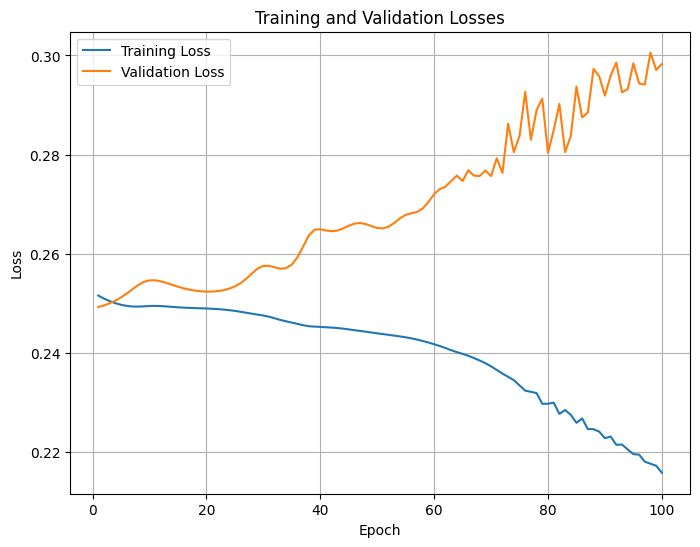

In [8]:
# Initialize empty lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.unsqueeze(1))
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor.unsqueeze(1))

    # Append losses to lists
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Plot the losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.grid(True)
plt.legend()
plt.show()

In [9]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)

    test_loss = criterion(test_outputs, y_test_tensor.unsqueeze(1))
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.2582


Optimal Threshold: 0.2149
Max F1 Score: 0.6849


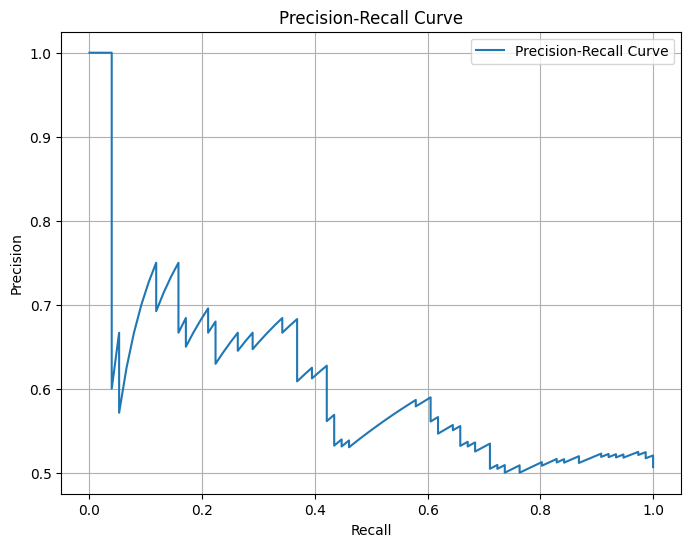

In [10]:
# Evaluation
precision, recall, thresholds = precision_recall_curve(y_test_tensor, test_outputs)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the optimal threshold that maximizes the F1 score
optimal_threshold = thresholds[f1_scores.argmax()]
max_f1_score = f1_scores.max()

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Max F1 Score: {max_f1_score:.4f}")

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()
plt.show()


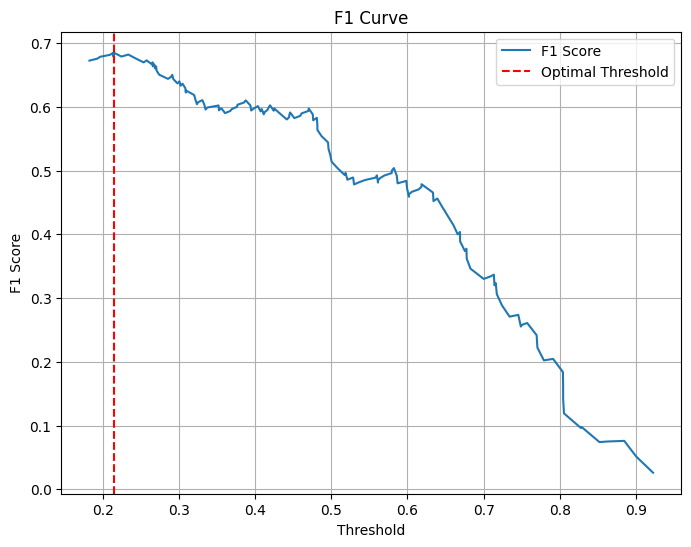

In [11]:
# Plot the F1 curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(x=optimal_threshold, color='r', linestyle='--', label='Optimal Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Curve')
plt.grid(True)
plt.legend()
plt.show()

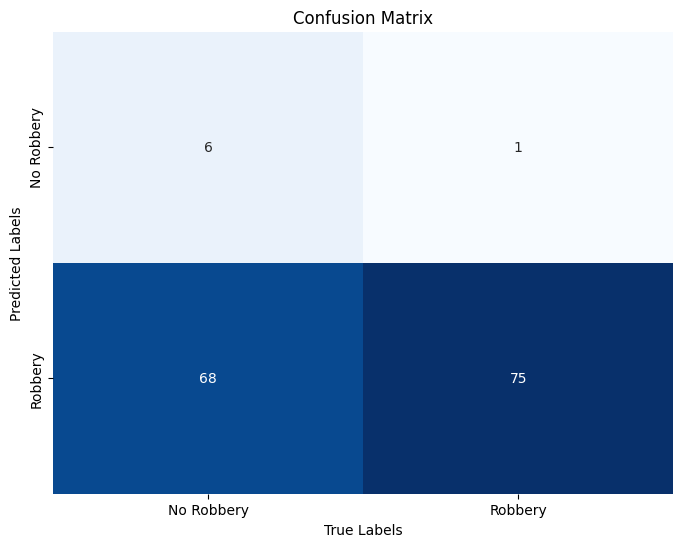

In [12]:
# Plot the Confusion matrix

test_outputs = (test_outputs >= optimal_threshold).float()  # Convert probabilities to 0 or 1
# test_outputs.squeeze(-1)

cm = confusion_matrix(y_test_tensor, test_outputs)
labels = ['No Robbery', 'Robbery']

# Transpose the confusion matrix and swap axis labels
cm_transposed = cm.T

plt.figure(figsize=(8, 6))
sns.heatmap(cm_transposed, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)  # Set labels for x and y axes
plt.title('Confusion Matrix')
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

In [ ]:
# Save the trained LSTM model
torch.save(model.state_dict(), 'model.pt')

In [ ]:
# Create an instance of your LSTM model
model = LSTMModel(input_size, hidden_size)

# Load the saved weights
model.load_state_dict(torch.load('model.pt'))
model.eval()  # Set the model to evaluation mode

---------------------**Activate API Endpoint** before proceeding-------------------------

In [ ]:
import requests


In [ ]:
for i in range(int(n_samples*0.15)):
    input_data = {
    "input":  X_test_scaled.tolist()[i] 
}
    response = requests.post('http://localhost:5000/predict', json=input_data).json()

    threshold = 0.5
    RBP = response["output"]

    actualRBP = y_test.tolist()[i]
    print("\n", i, "RBP =", RBP, "| actual RBP =", actualRBP, end=" ")
    # if RBP >= threshold:
    #     print("| WARNING! Impending robbery.", end="")
    if ((RBP >= threshold) & (actualRBP == 1)) | ((RBP < threshold) & (actualRBP == 0)):
        print("| CORRECT", end="")


In [ ]:
# study first doen lstm
# work on dynamic input
# try solar dataset